In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time

from torch.utils.data import DataLoader, Subset
from torch import optim
from torchvision import transforms, datasets
from scipy.special import softmax
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

/work/LAS/mdhuai-lab/wqi/grad/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup GPU Device

In [2]:
if torch.cuda.is_available():
    #args.device = torch.device("cuda")
    cudnn.benchmark = True
    device = "cuda:0"
else:
    device = "cpu"
print(f'device: {device}')

!nvidia-smi

device: cuda:0
Sat Oct  4 20:35:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:C1:00.0 Off |                    0 |
| N/A   27C    P0             57W /  500W |       4MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+--------------------------------

In [3]:
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed )
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

set_random_seed()

## Load Dataset

In [4]:
# Load CIFAR-10 dataset
data_mean = (0.4914, 0.4822, 0.4465)
data_std = (0.2023, 0.1994, 0.2010)
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std), ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std), ])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

cali_indices, test_indices = train_test_split(
    range(len(test_set)),
    test_size=0.5,
    stratify=test_set.targets, # Stratified sampling
)

cali_data = Subset(test_set, cali_indices)
test_data = Subset(test_set, test_indices)

num_classes = 10
batch_size = 128

# Dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
cali_loader = DataLoader(cali_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
print(f'Training data length: {len(train_data)}, calibration data length: {len(cali_data)}, test data length: {len(test_data)}')

# Get a single batch of data
train_images, train_labels = next(iter(train_loader))
cali_images, cali_labels = next(iter(cali_loader))
test_images, test_labels = next(iter(test_loader))

print(f'Training batch shape: {train_images.shape}, calibration batch shape: {cali_images.shape}, testing batch shape: {test_images.shape}')

Files already downloaded and verified
Files already downloaded and verified
Training data length: 50000, calibration data length: 5000, test data length: 5000
Training batch shape: torch.Size([128, 3, 32, 32]), calibration batch shape: torch.Size([128, 3, 32, 32]), testing batch shape: torch.Size([128, 3, 32, 32])


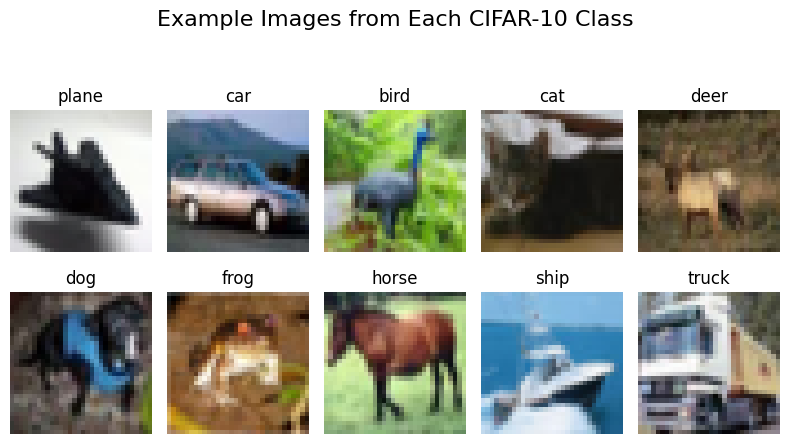

In [5]:
# Class names for CIFAR-10
class_names = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

images_to_plot = {}
for image, label in train_data:
    if label not in images_to_plot:
        images_to_plot[label] = image
    if len(images_to_plot) == 10:
        break

# Create example figures
fig, axes = plt.subplots(2, 5, figsize=(8, 5))
fig.suptitle('Example Images from Each CIFAR-10 Class', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(class_names):
        img_tensor = images_to_plot[i]
        img_unnormalized = img_tensor * torch.tensor(data_std).view(3, 1, 1) + torch.tensor(data_mean).view(3, 1, 1)
        img_unnormalized = img_unnormalized.numpy().transpose((1, 2, 0))
        img_unnormalized = np.clip(img_unnormalized, 0, 1)

        ax.imshow(img_unnormalized)
        ax.set_title(class_names[i])
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Load Model

In [6]:
# Build a simple convolutional neural network
class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network (CNN) designed for image classification,

    The architecture includes two convolutional blocks, an average pooling layer,
    dropout for regularization, and two fully connected layers for classification.
    """

    def __init__(self):
        super(SimpleCNN, self).__init__()

        # --- Convolutional Layers ---
        # 32x32x3 -> 16x16x16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1)
        
        # 16x16x16 -> 8x8x32
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1)

        # 8x8x32 -> 4x4x32
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # The flattened size is 32 channels * 4 * 4 spatial dimensions = 512
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, dropout=False):
        # First Convolutional Block
        x = F.relu(self.conv1(x))

        # Second Convolutional Block
        x = F.relu(self.conv2(x))

        # Pooling
        x = self.pool(x)

        # Flatten the feature map for the fully connected layers
        # x.size(0) is the batch dimension
        x = x.view(x.size(0), -1)

        # Dropout
        if dropout:
            x = self.dropout(x)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Output logits (no activation on the final layer for nn.CrossEntropyLoss)

        return x

In [7]:
# Move the model to the specified device (e.g., GPU)
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Train Model

In [8]:
epochs = 20 # Training epochs
lr = 0.01 # Learning rate

# Loss function
loss_func = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

def train(model, train_loader, loss_func, optimizer, epochs):
    model.train()
    loss_all = []
    for epoch in range(epochs):
        model.train()
        running_loss, n_batches, total, correct = 0.0, 0, 0, 0
    
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            n_batches += 1
    
        loss = running_loss / n_batches
        accuracy = 100 * correct / total
        print('Epoch %d training loss: %.3f training accuracy: %.3f%%' % (epoch, loss, accuracy))
    
        loss_all.append(loss)

    return loss_all

start_time = time.time()
loss_all = train(model, train_loader, loss_func, optimizer, epochs)
end_time = time.time()
print(f'Training time: {end_time - start_time:.2f}s')

Epoch 0 training loss: 1.824 training accuracy: 34.220%
Epoch 1 training loss: 1.415 training accuracy: 49.084%
Epoch 2 training loss: 1.276 training accuracy: 54.624%
Epoch 3 training loss: 1.181 training accuracy: 57.888%
Epoch 4 training loss: 1.095 training accuracy: 61.358%
Epoch 5 training loss: 1.026 training accuracy: 63.500%
Epoch 6 training loss: 0.968 training accuracy: 65.638%
Epoch 7 training loss: 0.907 training accuracy: 68.212%
Epoch 8 training loss: 0.857 training accuracy: 69.676%
Epoch 9 training loss: 0.818 training accuracy: 71.240%
Epoch 10 training loss: 0.773 training accuracy: 72.850%
Epoch 11 training loss: 0.744 training accuracy: 73.914%
Epoch 12 training loss: 0.706 training accuracy: 75.008%
Epoch 13 training loss: 0.674 training accuracy: 76.152%
Epoch 14 training loss: 0.639 training accuracy: 77.426%
Epoch 15 training loss: 0.618 training accuracy: 78.314%
Epoch 16 training loss: 0.592 training accuracy: 79.004%
Epoch 17 training loss: 0.561 training ac

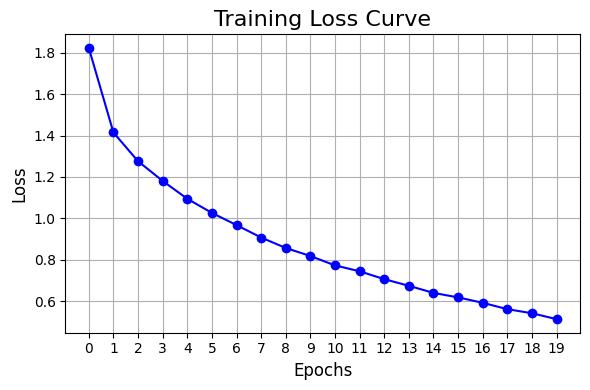

In [9]:
# Plot the loss curve
x_axis = np.arange(epochs)

plt.figure(figsize=(6, 4))
plt.plot(x_axis, loss_all, marker='o', linestyle='-', color='b')
plt.title('Training Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.xticks(x_axis) # Ensure integer epochs are shown
plt.tight_layout()

In [10]:
# Test the model
def test(model, test_loader):
    model.eval()
    total, correct = 0, 0
    
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

acc = test(model, test_loader)
print('Test accuracy: %.2f%%' % (100 * acc))

Test accuracy: 67.54%


## Uncertainty

## Expected Calibration Error (ECE)

In [11]:
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = len(np.unique(labels))
    return np.eye(num_classes)[labels]


def get_calibration_error(probs, labels, bin_upper_bounds, num_bins):
    if np.size(probs) == 0:
        return 0

    bin_indices = np.digitize(probs, bin_upper_bounds)
    sums = np.bincount(bin_indices, weights=probs, minlength=num_bins)
    sums = sums.astype(np.float64)
    counts = np.bincount(bin_indices, minlength=num_bins)
    counts = counts + np.finfo(sums.dtype).eps
    confs = sums / counts
    accs = np.bincount(bin_indices, weights=labels, minlength=num_bins) / counts

    calibration_errors = accs - confs

    weighting = counts / float(len(probs.flatten()))
    weighted_calibration_error = calibration_errors * weighting

    return np.sum(np.abs(weighted_calibration_error))

def ECE(probs, labels, num_bins=10):
    num_classes = probs.shape[1]
    labels_matrix = one_hot_encode(labels, probs.shape[1])

    bin_upper_bounds = np.histogram_bin_edges([], bins=num_bins, range=(0.0, 1.0))[1:]

    labels_matrix = labels_matrix[range(len(probs)), np.argmax(probs, axis=1)]
    probs_matrix = probs[range(len(probs)), np.argmax(probs, axis=1)]

    calibration_error = get_calibration_error(probs_matrix.flatten(), labels_matrix.flatten(), bin_upper_bounds, num_bins)

    return calibration_error

## Brier Score (BS)

In [12]:
def BS(probs, labels):
    n_samples, n_classes = probs.shape
    labels_matrix = one_hot_encode(labels, n_classes)
    brier_score = np.sum((probs - labels_matrix) ** 2) / n_samples

    return brier_score

## Softmax score

In [13]:
def get_outputs(model, data_loader):
    model.eval()
    all_labels, all_logits = [], []

    with torch.no_grad():
        for idx, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_labels.append(labels.detach().cpu().numpy())
            all_logits.append(outputs.detach().cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_logits = np.concatenate(all_logits, axis=0)

    return all_labels, all_logits

In [14]:
def evaluate_softmax(model, test_loader):
    def softmax_score(outputs):
        return softmax(outputs, axis=1)

    # Get labels and output logits
    test_labels, test_logits = get_outputs(model, test_loader)
    print(test_logits[0])
    
    # Get softmax score
    test_probs = softmax_score(test_logits)
    print(test_probs[0])
    
    # Compute uncertainty error
    ece = ECE(test_probs, test_labels)
    bs = BS(test_probs, test_labels)

    return ece, bs, test_probs, test_labels


ece_sm, bs_sm, test_probs_sm, test_labels = evaluate_softmax(model, test_loader)

print(f'ECE: {ece_sm:.4f}')
print(f'BS: {bs_sm:.4f}')

[ 3.905505   1.9153349  1.2039878 -1.6118441 -5.175998  -1.9490637
  3.2189898 -5.1936464  3.2052903  2.6368663]
[4.01299447e-01 5.48464768e-02 2.69286502e-02 1.61181157e-03
 4.56480193e-05 1.15043425e-03 2.01984882e-01 4.48494611e-05
 1.99236646e-01 1.12851106e-01]
ECE: 0.1059
BS: 0.4581


## Deep ensemble

In [15]:
# Train ensemble models
sub_models = []
num_ensembles = 3
epochs = 20
lr = 0.01

for i in range(num_ensembles):
    print(f'training submodel-{i}')
    sub_model = SimpleCNN().to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(sub_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    
    train(sub_model, train_loader, loss_func, optimizer, epochs)
    
    sub_models.append(sub_model)

training submodel-0
Epoch 0 training loss: 1.866 training accuracy: 32.612%
Epoch 1 training loss: 1.475 training accuracy: 46.704%
Epoch 2 training loss: 1.311 training accuracy: 53.160%
Epoch 3 training loss: 1.198 training accuracy: 57.242%
Epoch 4 training loss: 1.104 training accuracy: 60.480%
Epoch 5 training loss: 1.032 training accuracy: 63.302%
Epoch 6 training loss: 0.969 training accuracy: 65.542%
Epoch 7 training loss: 0.922 training accuracy: 67.354%
Epoch 8 training loss: 0.873 training accuracy: 69.132%
Epoch 9 training loss: 0.841 training accuracy: 70.172%
Epoch 10 training loss: 0.796 training accuracy: 71.704%
Epoch 11 training loss: 0.758 training accuracy: 73.224%
Epoch 12 training loss: 0.729 training accuracy: 74.208%
Epoch 13 training loss: 0.698 training accuracy: 75.168%
Epoch 14 training loss: 0.670 training accuracy: 76.162%
Epoch 15 training loss: 0.642 training accuracy: 77.162%
Epoch 16 training loss: 0.613 training accuracy: 78.280%
Epoch 17 training los

In [16]:
def evaluate_ensemble(sub_models, test_loader, num_ensembles=10):
    test_probs = []
    for i in range(num_ensembles):
        # load a sub model
        print(f'loading submodel-{i}')
        sub_model = sub_models[i]
        
        sub_test_labels, sub_test_logits = get_outputs(sub_model, test_loader)
        sub_test_probs = softmax(sub_test_logits, axis=1)
        test_probs.append(sub_test_probs)

    test_labels = sub_test_labels

    test_probs = np.array(test_probs)
    test_probs_mean, test_probs_std = test_probs.mean(0), test_probs.std(0)
    print(test_probs_mean[0])
    print(test_probs_std[0])

    ece = ECE(test_probs_mean, test_labels)
    bs = BS(test_probs_mean, test_labels)

    return ece, bs, test_probs_mean, test_labels


ece_de, bs_de, test_probs_de, test_labels = evaluate_ensemble(sub_models, test_loader, num_ensembles)

print(f'ECE: {ece_de:.4f}')
print(f'BS: {bs_de:.4f}')

loading submodel-0
loading submodel-1
loading submodel-2
[2.3942240e-01 9.2462949e-02 2.5444638e-04 9.4138115e-04 6.0456641e-05
 1.1760665e-05 4.4701117e-04 3.2900916e-06 6.6320020e-01 3.1960879e-03]
[3.2989836e-01 1.2147990e-01 1.7972608e-04 1.1971841e-03 7.4444877e-05
 8.1789194e-06 4.4748897e-04 2.3575901e-06 4.5639572e-01 3.2038006e-03]
ECE: 0.0203
BS: 0.3810


## MC dropout

In [17]:
def evaluate_dropout(model, test_loader, forward_passes=10):
    def enable_dropout(model):
        """ Function to enable the dropout layers during test-time """
        for m in model.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.train()

    def get_outputs_dropout(model, data_loader):
        all_labels, all_logits = [], []
        model.eval()
        enable_dropout(model)
        with torch.no_grad():
            for idx, (images, labels) in enumerate(data_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, dropout=True)

                all_labels.append(labels.detach().cpu().numpy())
                all_logits.append(outputs.detach().cpu().numpy())

            all_labels = np.concatenate(all_labels, axis=0)
            all_logits = np.concatenate(all_logits, axis=0)

        return all_labels, all_logits

    test_probs = []
    for i in range(forward_passes):
        print(f'forwarding pass-{i}')
        test_labels, test_logits = get_outputs_dropout(model, test_loader)
        test_probs.append(softmax(test_logits, axis=1))

    test_probs = np.array(test_probs)
    test_probs_mean, test_probs_std = test_probs.mean(0), test_probs.std(0)

    ece = ECE(test_probs_mean, test_labels)
    bs = BS(test_probs_mean, test_labels)

    return ece, bs, test_probs_mean, test_labels


ece_mc, bs_mc, test_probs_mc, test_labels = evaluate_dropout(model, test_loader)

print(f'ECE: {ece_mc:.4f}')
print(f'BS: {bs_mc:.4f}')

forwarding pass-0
forwarding pass-1
forwarding pass-2
forwarding pass-3
forwarding pass-4
forwarding pass-5
forwarding pass-6
forwarding pass-7
forwarding pass-8
forwarding pass-9
ECE: 0.0318
BS: 0.4536


## Temperature scaling

In [18]:
class TemperatureScaling():

    def __init__(self, temp=1, maxiter=50, solver="BFGS"):
        """
        Initialize class

        Params:
            temp (float): starting temperature, default 1
            maxiter (int): maximum iterations done by optimizer, however 8 iterations have been maximum.
        """
        self.temp = temp
        self.maxiter = maxiter
        self.solver = solver

    def _loss_fun(self, x, probs, true):
        # Calculates the loss using log-loss (cross-entropy loss)
        scaled_probs = self.predict(probs, x)
        loss = log_loss(y_true=true, y_pred=scaled_probs)
        return loss

    # Find the temperature
    def fit(self, logits, true):
        """
        Trains the model and finds optimal temperature

        Params:
            logits: the output from neural network for each class (shape [samples, classes])
            true: one-hot-encoding of true labels.

        Returns:
            the results of optimizer after minimizing is finished.
        """

        true = true.flatten()  # Flatten y_val
        opt = minimize(self._loss_fun, x0=1, args=(logits, true), options={'maxiter': self.maxiter}, method=self.solver)
        self.temp = opt.x[0]

        return opt

    def predict(self, logits, temp=None):
        """
        Scales logits based on the temperature and returns calibrated probabilities

        Params:
            logits: logits values of data (output from neural network) for each class (shape [samples, classes])
            temp: if not set use temperatures find by model or previously set.

        Returns:
            calibrated probabilities (nd.array with shape [samples, classes])
        """

        if not temp:
            return softmax(logits / self.temp, axis=1)
        else:
            return softmax(logits / temp, axis=1)

def evaluate_ts(model, cali_loader, test_loader):
    # calibration data
    cali_labels, cali_logits = get_outputs(model, cali_loader)
    test_lables, test_logits = get_outputs(model, test_loader)
    
    ts = TemperatureScaling()
    ts.fit(cali_logits, cali_labels)
    test_probs_ts = ts.predict(test_logits)
    
    ece = ECE(test_probs_ts, test_labels)
    bs = BS(test_probs_ts, test_labels)

    return ece, bs, test_probs_ts, test_labels

ece_ts, bs_ts, test_probs_ts, test_labels = evaluate_ts(model, cali_loader, test_loader)

print(f'ECE: {ece_ts:.4f}')
print(f'BS: {bs_ts:.4f}')

ECE: 0.0161
BS: 0.4409


## Plot

In [19]:
def get_calibration(probs, labels, bin_upper_bounds, num_bins):
    if np.size(probs) == 0:
        return 0

    bin_indices = np.digitize(probs, bin_upper_bounds)
    sums = np.bincount(bin_indices, weights=probs, minlength=num_bins)
    sums = sums.astype(np.float64)
    counts = np.bincount(bin_indices, minlength=num_bins)
    counts = counts + np.finfo(sums.dtype).eps
    confs = sums / counts
    accs = np.bincount(bin_indices, weights=labels, minlength=num_bins) / counts

    return confs, accs

def get_bin_info(probs, labels, num_bins=10):

    num_classes = probs.shape[1]
    labels_matrix = one_hot_encode(labels, probs.shape[1])

    bin_upper_bounds = np.histogram_bin_edges([], bins=num_bins, range=(0.0, 1.0))[1:]

    labels_matrix = labels_matrix[range(len(probs)), np.argmax(probs, axis=1)]
    probs_matrix = probs[range(len(probs)), np.argmax(probs, axis=1)]

    confs, accs = get_calibration(probs_matrix.flatten(), labels_matrix.flatten(), bin_upper_bounds, num_bins)

    return confs, accs

def rel_diagram_sub(min_confs, min_accs, ece, M=10):
    # plt.rcParams['pdf.fonttype'] = 42
    # plt.rcParams['ps.fonttype'] = 42
    # plt.rcParams['font.family'] = 'serif'
    # plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams['font.size'] = '16'

    colors = ['#0000ff', '#FF5959', 'black']

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex='col', sharey='row')

    min_acc_conf = np.column_stack([min_accs, min_confs])
    min_outputs = min_acc_conf[:, 0]
    min_gap = min_acc_conf[:, 1]

    bin_size = 1/M
    positions = np.arange(0+bin_size/2, 1+bin_size/2, bin_size)

    gap_plt1 = ax1.bar(positions, min_gap, width = bin_size, edgecolor = colors[1], color = colors[1], alpha = 0.5, hatch='/', label="Gap", linewidth=2, zorder=2)
    output_plt1 = ax1.bar(positions, min_outputs, width = bin_size, edgecolor = "black", color = colors[0], label="Outputs", zorder = 3)

    for i in range(M):
        if min_accs[i] > min_confs[i]:
            ax1.bar(positions[i], min_accs[i]-min_confs[i], bottom=min_confs[i], width=bin_size, edgecolor=colors[1], color=colors[1], alpha=0.5, hatch='/', linewidth=2, zorder=3)

    ax1.set_axisbelow(True)
    ax1.grid(zorder=0, which='major', color='grey', linestyle='--', linewidth=1, alpha=0.2)
    ax1.plot([0,1], [0,1], linestyle = "--", color=colors[2], zorder = 4)
    ax1.legend(handles = [gap_plt1, output_plt1], frameon=True, fontsize=14)
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    ax1.set_xlabel('Confidence')
    ax1.set_ylabel('Accuracy')

    ax1.text(
        0.95, 0.05,                         
        f"ECE = {ece:.3f}",                  
        ha='right', va='bottom',            
        transform=ax1.transAxes,            
        fontsize=14,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

    plt.show()

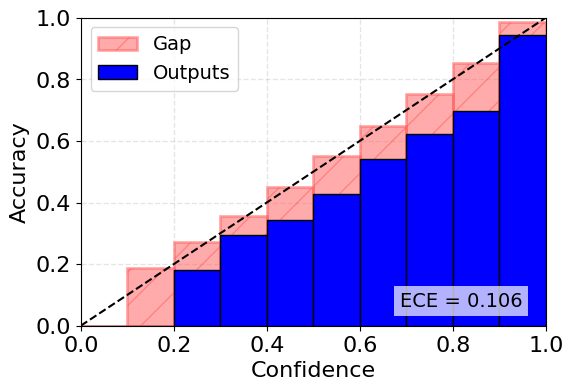

In [20]:
# Softmax
confs, accs = get_bin_info(test_probs_sm, test_labels)
if len(confs) > 10:
    confs[9] = (confs[9] + confs[10]) / 2
    confs = confs[:10]
    accs[9] = (accs[9] + accs[10]) / 2
    accs = accs[:10]
     
rel_diagram_sub(confs, accs, ece_sm)

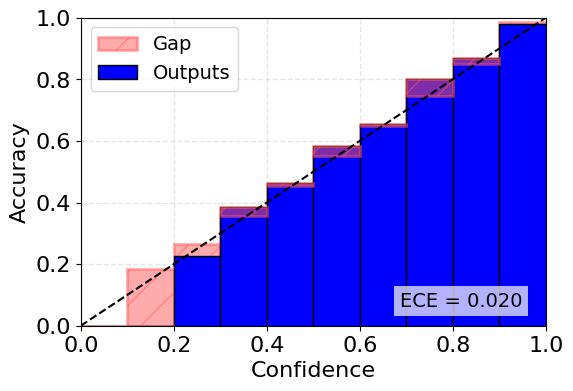

In [21]:
# Deep ensemble
confs, accs = get_bin_info(test_probs_de, test_labels)
if len(confs) > 10:
    confs[9] = (confs[9] + confs[10]) / 2
    confs = confs[:10]
    accs[9] = (accs[9] + accs[10]) / 2
    accs = accs[:10]
     
rel_diagram_sub(confs, accs, ece_de)

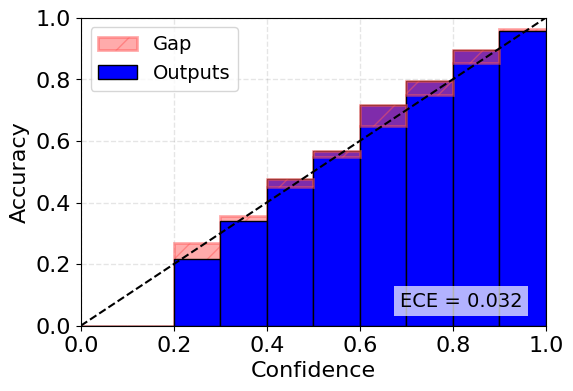

In [22]:
# MC dropout
confs, accs = get_bin_info(test_probs_mc, test_labels)
if len(confs) > 10:
    confs[9] = (confs[9] + confs[10]) / 2
    confs = confs[:10]
    accs[9] = (accs[9] + accs[10]) / 2
    accs = accs[:10]
     
rel_diagram_sub(confs, accs, ece_mc)

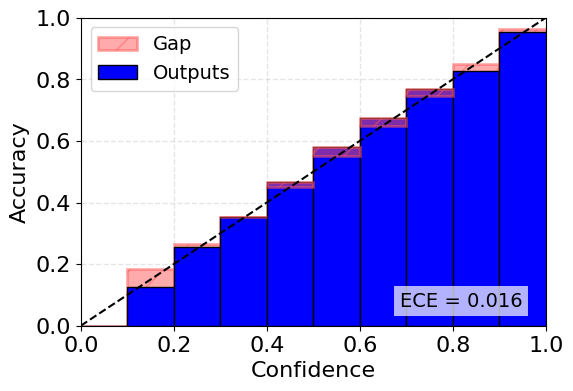

In [23]:
# Temperature scaling
confs, accs = get_bin_info(test_probs_ts, test_labels)
if len(confs) > 10:
    confs[9] = (confs[9] + confs[10]) / 2
    confs = confs[:10]
    accs[9] = (accs[9] + accs[10]) / 2
    accs = accs[:10]
     
rel_diagram_sub(confs, accs, ece_ts)